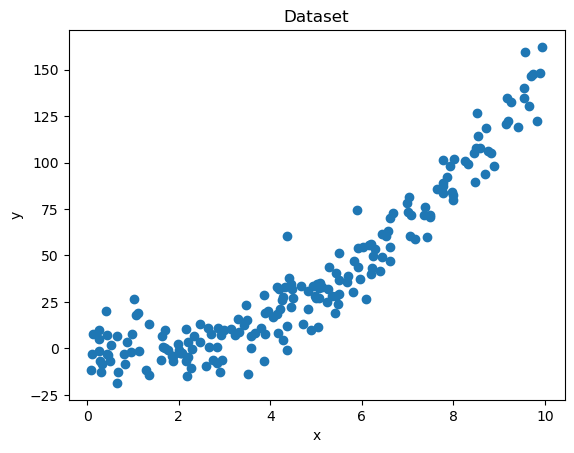

Train R^2: 0.941
Train MSE: 109.985
Test  R^2: 0.953
Test  MSE: 90.119


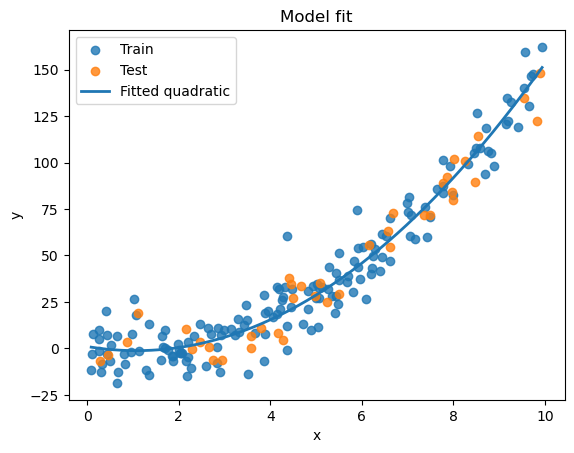

In [ ]:
#Exercise 1

# One simple cell/script that does everything (a–g)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --- data (a + c plot) ---
np.random.seed(2)
x = np.random.uniform(0, 10, 200)
y = 2 * x**2 - 5 * x + 3 + np.random.normal(0, 10, 200)

plt.scatter(x, y)
plt.xlabel("x"); plt.ylabel("y"); plt.title("Dataset"); plt.show()

# --- split (b) ---
X = x.reshape(-1, 1)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# --- choose & train quadratic model (c,d) ---
poly = PolynomialFeatures(degree=2, include_bias=False)  # [x, x^2]
Xtr_poly = poly.fit_transform(Xtr)
model = LinearRegression().fit(Xtr_poly, ytr)

# --- train metrics (e) ---
yhat_tr = model.predict(Xtr_poly)
print("Train R^2:", round(r2_score(ytr, yhat_tr), 3))
print("Train MSE:", round(mean_squared_error(ytr, yhat_tr), 3))

# --- test metrics (f) ---
Xte_poly = poly.transform(Xte)
yhat_te = model.predict(Xte_poly)
print("Test  R^2:", round(r2_score(yte, yhat_te), 3))
print("Test  MSE:", round(mean_squared_error(yte, yhat_te), 3))

# --- visualize fit (g) ---
xg = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
yg = model.predict(poly.transform(xg))

plt.scatter(Xtr, ytr, label="Train", alpha=0.8)
plt.scatter(Xte, yte, label="Test",  alpha=0.8)
plt.plot(xg, yg, linewidth=2, label="Fitted quadratic")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Model fit"); plt.legend()
plt.show()


In [ ]:
#assignment 2



In [ ]:
#assignment 3.1

import os
import numpy as np
import pandas as pd

# Robust loader: try common extensions for a given base name
def load_any(base_name, search_cwd=True):
    candidates = [base_name, base_name + '.xlsx', base_name + '.xls', base_name + '.csv']
    cwd = os.getcwd() if search_cwd else ''
    for name in candidates:
        # if an absolute or relative path was provided, check directly
        if os.path.exists(name):
            path = name
        else:
            path = os.path.join(cwd, name) if cwd else name
        if os.path.exists(path):
            if path.lower().endswith('.csv'):
                return pd.read_csv(path)
            else:
                return pd.read_excel(path)
    # nothing found
    raise FileNotFoundError(f'Could not find any of: {candidates} in {cwd}')

# Attempt to load the expected datasets. If the files are missing, the error below
# will list the current working directory to help debugging.
try:
    training_data = load_any('training')
    prediction_data = load_any('predictions_training')
except FileNotFoundError as e:
    print('Error loading data files:')
    print(e)
    print('Current working directory:', os.getcwd())
    print('Files here:', sorted(os.listdir('.')))
    # Re-raise so that the notebook cell clearly fails (you can comment this out to continue interactively)
    raise

# helper: ensure required columns exist and coerce numeric types
def validate_and_prepare(df, name):
    required = {'filename', 'min_r', 'min_c', 'max_r', 'max_c'}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f'{name} is missing required columns: {missing}. Found: {list(df.columns)}')
    # strip filename spaces and coerce numeric columns
    df = df.copy()
    df['filename'] = df['filename'].astype(str).str.strip()
    for c in ['min_r','min_c','max_r','max_c']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

training_data = validate_and_prepare(training_data, 'training_data')
prediction_data = validate_and_prepare(prediction_data, 'prediction_data')

# IOU for one pair of boxes: boxes are [min_r, min_c, max_r, max_c]
def calculate_iou(boxA, boxB):
    # intersection coords
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])
    # intersection area (ensure non-negative)
    inter_width = max(0.0, float(xB) - float(xA))
    inter_height = max(0.0, float(yB) - float(yA))
    intersection_area = inter_width * inter_height
    # areas of the boxes (if invalid coordinates produce zero or NaN, area becomes 0)
    boxA_area = max(0.0, float(boxA[2]) - float(boxA[0])) * max(0.0, float(boxA[3]) - float(boxA[1]))
    boxB_area = max(0.0, float(boxB[2]) - float(boxB[0])) * max(0.0, float(boxB[3]) - float(boxB[1]))
    union_area = boxA_area + boxB_area - intersection_area
    if union_area <= 0:
        return 0.0
    return intersection_area / union_area

def mean_iou_by_filename(true_df, pred_df):
    # keep only required columns and rename preds to avoid conflicts
    t = true_df[['filename','min_r','min_c','max_r','max_c']].copy()
    p = pred_df[['filename','min_r','min_c','max_r','max_c']].copy()
    p = p.rename(columns={'min_r':'p_min_r','min_c':'p_min_c','max_r':'p_max_r','max_c':'p_max_c'})
    # normalize filenames
    t['filename'] = t['filename'].astype(str).str.strip()
    p['filename'] = p['filename'].astype(str).str.strip()
    # inner join on filename — if no matches, result is empty
    df = t.merge(p, on='filename', how='inner')
    if df.empty:
        return 0.0, [], df[['filename']]
    ious = []
    for _, row in df.iterrows():
        true_box = [row['min_r'], row['min_c'], row['max_r'], row['max_c']]
        pred_box = [row['p_min_r'], row['p_min_c'], row['p_max_r'], row['p_max_c']]
        ious.append(calculate_iou(true_box, pred_box))
    mean_val = float(np.mean(ious)) if ious else 0.0
    return mean_val, ious, df[['filename']]

# Run evaluation
mean_iou_value, all_ious, filenames = mean_iou_by_filename(training_data, prediction_data)

# Display results
if len(all_ious) == 0:
    print('No matching filenames between ground truth and predictions — empty merge.')
else:
    print('Individual IOUs for each image:')
    for i, (fname, val) in enumerate(zip(filenames['filename'], all_ious)):
        print(f'{i+1}. {fname} → IOU = {val:.3f}')
    print('Mean IOU across all images:', round(mean_iou_value, 3))

In [ ]:
#assignment 3.2

import statsmodels.api as sm
import numpy as np

#Read file
train_data = pd.read_excel('training.xlsx')

#Prepare training data
train_y = train_data['category']
train_x = all_ious

#add constant
X = sm.add_constant(train_x)
y = train_y

#Create and fit logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)

#Make predictions
pred_probabilities = model.predict_proba(X)[:, 1]

#Calculate R-square on training data
r_square = model.score(X, y)
print(r_square)

# It's important to test the model using the test set because it indicates how well the model performs on unseen data.
# Based on this we can assess whether the model is suited for predictions.